In [1]:

#Import the required packages
import cbadc
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)

In [2]:
# Set quadrature leapfrog system parameters
N = 7
ENOB = 12
BW = 44.1e3 / 2.0
M = N
K = (1 << 5)
IIR_DELAY = 6
IIR_DELAY_RANGE = [0, K]

simulation_length = 1 << 13
warm_up = 1 << 10

In [3]:
# Initialize quadrature leapfrog system parameters
analog_frontend = cbadc.synthesis.get_leap_frog(ENOB=ENOB, N=N, BW=BW)
T = analog_frontend.digital_control.clock.T
fs = 1.0 / T
OSR = fs / (2 * BW)
OSR = int(np.ceil(OSR))
DSR = OSR >> 0

print(analog_frontend.analog_system)
print(f"fs: {fs:.2e}\nOSR: {OSR:.2f}")
print(f"beta = {analog_frontend.analog_system.A[1,0] : .2e}")
print(f"alpha = {analog_frontend.analog_system.A[0,1] : .2e}")
print(f"gamma = {-analog_frontend.analog_system.A[1,0] / analog_frontend.analog_system.A[0,1] : .2f}")

The analog system is parameterized as:
A =
[[ 0.00e+00  2.89e+04  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [-1.66e+05  0.00e+00  2.89e+04  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00 -1.66e+05  0.00e+00  2.89e+04  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00 -1.66e+05  0.00e+00  2.89e+04  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -1.66e+05  0.00e+00  2.89e+04  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.66e+05  0.00e+00  2.89e+04]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.66e+05  0.00e+00]],
B =
[[-1.66e+05]
 [ 0.00e+00]
 [ 0.00e+00]
 [ 0.00e+00]
 [ 0.00e+00]
 [ 0.00e+00]
 [ 0.00e+00]],
CT = 
[[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+

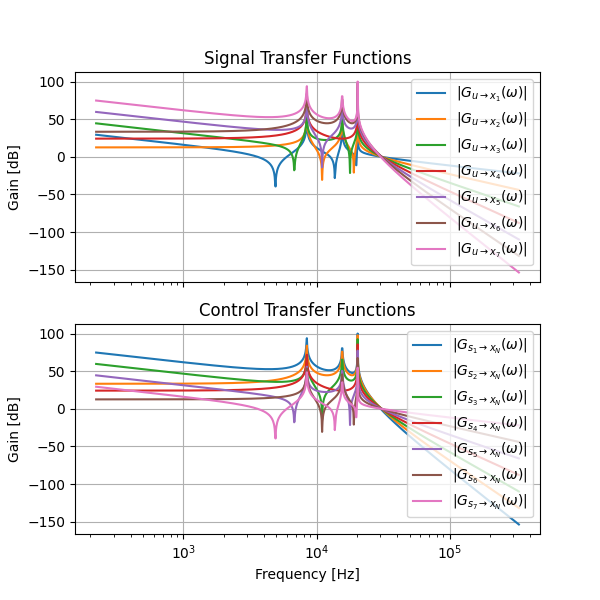

In [4]:
frequencies = np.geomspace(BW * 1e-2, fs, 1000)
signal_transfer_functions = analog_frontend.analog_system.transfer_function_matrix(
    2 * np.pi * frequencies
)
control_transfer_functions = (
    analog_frontend.analog_system.control_signal_transfer_function_matrix(
        2 * np.pi * frequencies
    )
)

fig, ax = plt.subplots(2, sharex=True)
for i in range(N):
    ax[0].semilogx(
        frequencies,
        20 * np.log10(np.abs(signal_transfer_functions[i, 0, :])),
        label="$|G_{u \\to x_%i}(\omega)|$" % (i + 1),
    )
    ax[1].semilogx(
        frequencies,
        20 * np.log10(np.abs(control_transfer_functions[-1, i, :])),
        label="$|G_{s_%i \\to x_N}(\omega)|$" % (i + 1),
    )
for i in range(2):
    ax[i].set_ylabel("Gain [dB]")
    ax[i].legend()
    ax[i].grid(True)

ax[0].set_title("Signal Transfer Functions")
ax[1].set_title("Control Transfer Functions")
ax[1].set_xlabel("Frequency [Hz]")
fig.set_size_inches(6, 6)


In [5]:
# train signal
kappa_0 = 2e-1

r_seq = kappa_0 * (2.0 * np.random.randint(0, 2, simulation_length + warm_up) - 1.0)
r_signal = cbadc.analog_signal.ZeroOrderHold(r_seq, T)

In [6]:
# setup training simulator
atol = 1e-15
rtol = 1e-10
simulator = cbadc.simulator.PreComputedControlSignalsSimulator(
    analog_frontend.analog_system,
    analog_frontend.digital_control,
    [
        r_signal,
    ],
    atol=atol,
    rtol=rtol,
)

INFO:cbadc.simulator.numerical_simulator:Executing pre-computations.


In [7]:
# simulate
s = np.zeros((simulation_length, M))
x = np.zeros((simulation_length, M))

for i in cbadc.utilities.show_status(range(warm_up)):
    next(simulator)

for i in cbadc.utilities.show_status(range(simulation_length)):
    s[i, :] = 2.0 * next(simulator) - 1.0
    x[i, :] = simulator.state_vector()


100%|██████████| 8192/8192 [00:30<00:00, 272.21it/s]


Text(0.5, 1.0, 'PSD')

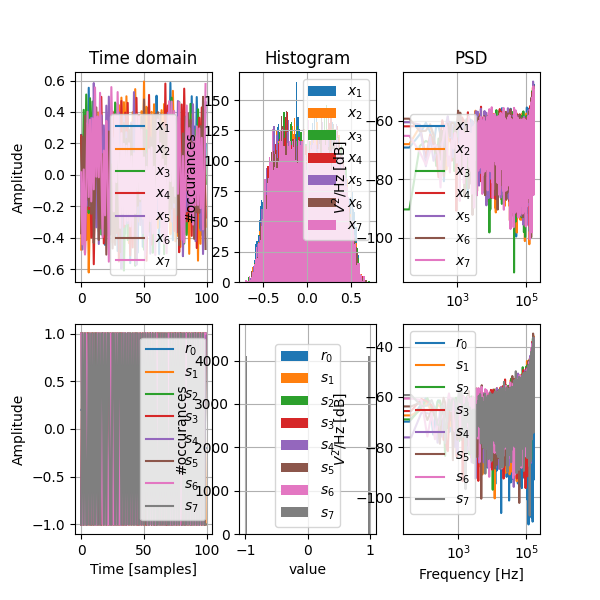

In [8]:
from_index = 0
to_index = 100

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(6, 6)

# r_0
ax[1, 0].plot(r_seq[from_index:to_index], label="$r_0$")
ax[1, 1].hist(r_seq, bins=100, label="$r_0$")
f, psd = cbadc.utilities.compute_power_spectral_density(r_seq, fs=fs)
ax[1, 2].semilogx(f, 10 * np.log10(psd), label="$r_0$")
for n in range(N):
    # x_n
    ax[0, 0].plot(x[from_index:to_index, n], label="$x_%i$" % (n + 1))
    ax[0, 1].hist(x[:, n], bins=100, label="$x_%i$" % (n + 1))
    f, psd = cbadc.utilities.compute_power_spectral_density(x[:, n], fs=fs)
    ax[0, 2].semilogx(f, 10 * np.log10(psd), label="$x_%i$" % (n + 1))

    # s_n
    ax[1, 0].plot(s[from_index:to_index, n], label="$s_%i$" % (n + 1))
    ax[1, 1].hist(s[:, n], bins=100, label="$s_%i$" % (n + 1))
    f, psd = cbadc.utilities.compute_power_spectral_density(s[:, n], fs=fs)
    ax[1, 2].semilogx(f, 10 * np.log10(psd), label="$s_%i$" % (n + 1))

for i in range(2):
    for j in range(3):
        ax[i, j].grid(True)
        ax[i, j].legend()
    ax[i, 0].set_ylabel("Amplitude")
    ax[i, 1].set_ylabel("#occurances")
    ax[i, 2].set_ylabel("$V^2/\\mathrm{Hz}$ [dB]")

ax[1, 0].set_xlabel("Time [samples]")
ax[1, 1].set_xlabel("value")
ax[1, 2].set_xlabel("Frequency [Hz]")

ax[0, 0].set_title("Time domain")
ax[0, 1].set_title("Histogram")
ax[0, 2].set_title("PSD")

In [9]:
# Validate with test signal
amplitude = 1e-0
frequency = fs
while frequency > BW / 8:
    frequency /= 2

test_signal = cbadc.analog_signal.Sinusoidal(
    frequency=frequency, amplitude=amplitude, phase=0.0, offset=0.0
)

In [10]:
test_simulator = cbadc.simulator.PreComputedControlSignalsSimulator(
    analog_frontend.analog_system,
    analog_frontend.digital_control,
    [
        test_signal,
    ],
    atol=atol,
    rtol=rtol,
)

INFO:cbadc.simulator.numerical_simulator:Executing pre-computations.


In [11]:
# Simulate
simulation_length = 1 << 14
s_test = np.zeros((simulation_length, M))
x_test = np.zeros((simulation_length, M))

for i in cbadc.utilities.show_status(range(warm_up)):
    next(test_simulator)

for i in cbadc.utilities.show_status(range(simulation_length)):
    s_test[i, :] = 2.0 * next(test_simulator) - 1.0
    x_test[i, :] = test_simulator.state_vector()

100%|██████████| 16384/16384 [00:21<00:00, 762.10it/s]


Text(0.5, 1.0, 'PSD')

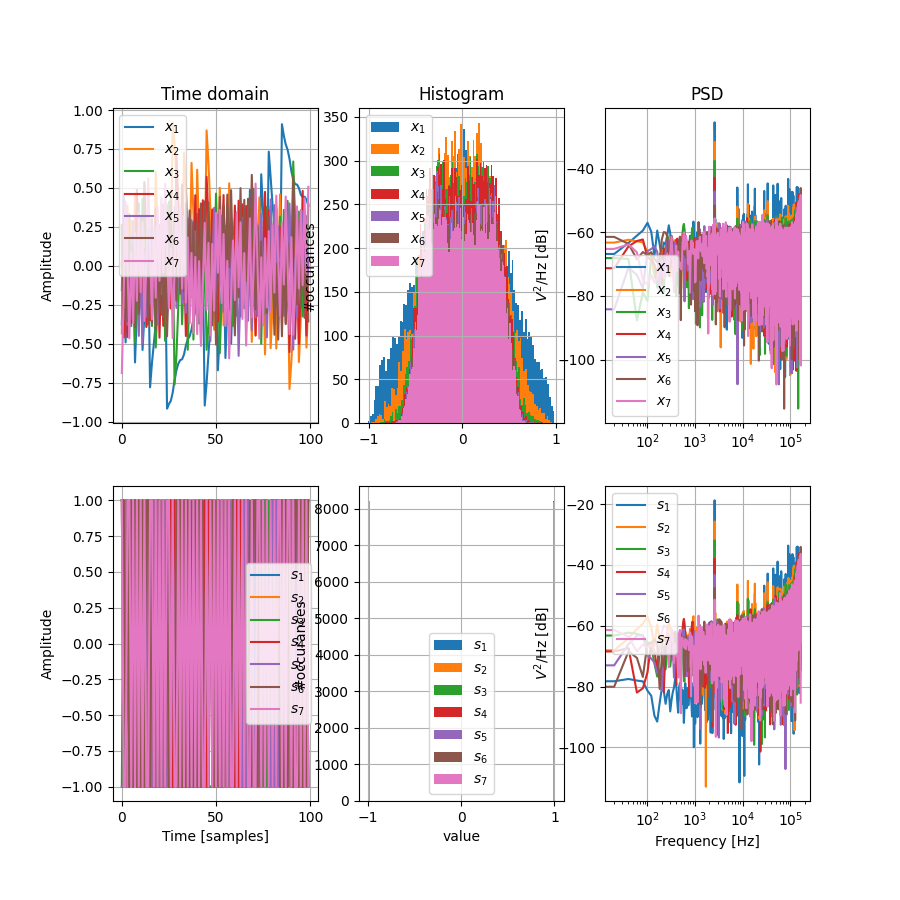

In [12]:
from_index = 0
to_index = 100

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(9, 9)

for n in range(N):
    # x_n
    ax[0, 0].plot(x_test[from_index:to_index, n], label="$x_%i$" % (n + 1))
    ax[0, 1].hist(x_test[:, n], bins=100, label="$x_%i$" % (n + 1))
    f, psd = cbadc.utilities.compute_power_spectral_density(x_test[:, n], fs=fs)
    ax[0, 2].semilogx(f, 10 * np.log10(psd), label="$x_%i$" % (n + 1))

    # s_n
    ax[1, 0].plot(s_test[from_index:to_index, n], label="$s_%i$" % (n + 1))
    ax[1, 1].hist(s_test[:, n], bins=100, label="$s_%i$" % (n + 1))
    f, psd = cbadc.utilities.compute_power_spectral_density(s_test[:, n], fs=fs)
    ax[1, 2].semilogx(f, 10 * np.log10(psd), label="$s_%i$" % (n + 1))

for i in range(2):
    for j in range(3):
        ax[i, j].grid(True)
        ax[i, j].legend()
    ax[i, 0].set_ylabel("Amplitude")
    ax[i, 1].set_ylabel("#occurances")
    ax[i, 2].set_ylabel("$V^2/\\mathrm{Hz}$ [dB]")

ax[1, 0].set_xlabel("Time [samples]")
ax[1, 1].set_xlabel("value")
ax[1, 2].set_xlabel("Frequency [Hz]")

ax[0, 0].set_title("Time domain")
ax[0, 1].set_title("Histogram")
ax[0, 2].set_title("PSD")

In [13]:
# Decimate and batch test control signals
s_test_decimated = cbadc.digital_estimator.decimate(s_test, DSR)
print(s_test.shape)
print(s_test_decimated.shape)


(16384, 7)
(2048, 7)


In [14]:
# make reference filter
from scipy import signal

bw_rel = DSR / (2.0 * OSR)
m_3dB = 1 / np.sqrt(2.0)
h0 = signal.firwin2(K, [0, bw_rel, 1], [1, m_3dB, 0])

In [15]:
# Decimate and batch control signals and reference sequence
s_decimated = cbadc.digital_estimator.decimate(s, DSR)

r_decimated = cbadc.digital_estimator.decimate(r_seq[warm_up:], DSR)
r_batched = cbadc.digital_estimator.batch(r_decimated, K)
r_filtered = np.dot(r_batched, h0).reshape((1, -1))

print(s.shape)
print(s_decimated.shape)

print(r_seq.shape)
print(r_decimated.shape)
print(r_batched.shape)
print(r_filtered.shape)

(8192, 7)
(1024, 7)
(9216,)
(1024,)
(992, 32)
(1, 992)


In [16]:
# Solve using least squares
lstsq_estimator = cbadc.digital_estimator.AdaptiveFIRFilter(M, K, L=1)
lstsq_estimator.lstsq(
    x=s_decimated,
    y=r_filtered,
)

INFO:cbadc.digital_estimator.adaptive_filter:loss = [ 1.78e-05], offset = [-2.36e-07]


array([ 1.78e-05])

In [17]:
lstsq_iir_estimator = cbadc.digital_estimator.AdaptiveIIRFilter(M, K, L=1)
lstsq_iir_estimator.lstsq(
    x=s_decimated, y=r_filtered, x_validate=s_test_decimated, delay=IIR_DELAY_RANGE
)

INFO:cbadc.digital_estimator.adaptive_filter:Delay set as: 6
INFO:cbadc.digital_estimator.adaptive_filter:loss = [ 4.40e-06], offset = [ 2.87e-07]


array([ 4.40e-06])

In [18]:
# Solve using RLS
epochs = 1 << 1
delta = 1e-6
lambda_ = 1e0 - 1e-12

rls_estimator = cbadc.digital_estimator.AdaptiveFIRFilter(M, K, L=1)
rls_estimator.rls(
    x=s_decimated,
    y=r_filtered.reshape((1, -1)),
    epochs=epochs,
    verbose=True,
    delta=delta,
    lambda_=lambda_,
)


INFO:cbadc.digital_estimator.adaptive_filter:
Training using RLS for:
- epochs = 2,
- delta = 1e-06,
- lambda = 0.999999999999,
- and shuffle set to False.
100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


array([ 1.79e-08])

In [19]:
rls_iir_estimator = cbadc.digital_estimator.AdaptiveIIRFilter(M, K, L=1)
rls_iir_estimator.rls(
    x=s_decimated,
    y=r_filtered.reshape((1, -1)),
    epochs=epochs,
    verbose=True,
    delta=delta,
    lambda_=lambda_,
    delay=IIR_DELAY,
)

INFO:cbadc.digital_estimator.adaptive_filter:
Training using RLS for:
- epochs = 2,
- delta = 1e-06,
- lambda = 0.999999999999,
- and shuffle set to False.
100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


array([ 4.76e-09])

In [20]:
# Solve using LMS
epochs = 1 << 8
batch_size = 1 << 1
learning_rate = 1e-2
momentum = 0.91

lms_estimator = cbadc.digital_estimator.AdaptiveFIRFilter(M, K, L=1)
lms_estimator.lms(
    x=s_decimated,
    y=r_filtered.reshape((1, -1)),
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    shuffle=False,
    verbose=True,
)

INFO:cbadc.digital_estimator.adaptive_filter:
Training using LMS for:
- epochs = 256,
- batch size = 2,
- learning rate = 0.01,
- momentum = 0.91,
- and shuffle set to False.
  0%|          | 0/256 [00:00<?, ?it/s]INFO:cbadc.digital_estimator.adaptive_filter:epoch 0: loss = [ 1.12e-03], offset = [[ 4.36e-03]]
INFO:cbadc.digital_estimator.adaptive_filter:epoch 1: loss = [ 6.84e-04], offset = [[ 3.65e-03]]
  1%|          | 2/256 [00:00<00:14, 17.60it/s]INFO:cbadc.digital_estimator.adaptive_filter:epoch 2: loss = [ 4.52e-04], offset = [[ 3.02e-03]]
INFO:cbadc.digital_estimator.adaptive_filter:epoch 3: loss = [ 3.13e-04], offset = [[ 2.55e-03]]
  2%|▏         | 4/256 [00:00<00:17, 14.39it/s]INFO:cbadc.digital_estimator.adaptive_filter:epoch 4: loss = [ 2.24e-04], offset = [[ 2.22e-03]]
INFO:cbadc.digital_estimator.adaptive_filter:epoch 5: loss = [ 1.64e-04], offset = [[ 2.01e-03]]
  2%|▏         | 6/256 [00:00<00:18, 13.74it/s]INFO:cbadc.digital_estimator.adaptive_filter:epoch 6: loss = [ 

array([ 1.83e-08])

In [21]:
lms_iir_estimator = cbadc.digital_estimator.AdaptiveIIRFilter(M, K, L=1)
lms_iir_estimator.lms(
    x=s_decimated,
    y=r_filtered.reshape((1, -1)),
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    verbose=True,
    delay=IIR_DELAY,
)

INFO:cbadc.digital_estimator.adaptive_filter:
Training using LMS for:
- epochs = 256,
- batch size = 2,
- learning rate = 0.01,
- momentum = 0.91,
- and shuffle set to False.
  0%|          | 0/256 [00:00<?, ?it/s]INFO:cbadc.digital_estimator.adaptive_filter:epoch 0: loss = [ 1.11e-03], offset = [[ 6.42e-03]]
INFO:cbadc.digital_estimator.adaptive_filter:epoch 1: loss = [ 6.77e-04], offset = [[ 5.39e-03]]
INFO:cbadc.digital_estimator.adaptive_filter:epoch 2: loss = [ 4.54e-04], offset = [[ 4.95e-03]]
  1%|          | 3/256 [00:00<00:09, 27.36it/s]INFO:cbadc.digital_estimator.adaptive_filter:epoch 3: loss = [ 3.24e-04], offset = [[ 4.77e-03]]
INFO:cbadc.digital_estimator.adaptive_filter:epoch 4: loss = [ 2.43e-04], offset = [[ 4.71e-03]]
INFO:cbadc.digital_estimator.adaptive_filter:epoch 5: loss = [ 1.88e-04], offset = [[ 4.69e-03]]
  2%|▏         | 6/256 [00:00<00:10, 24.21it/s]INFO:cbadc.digital_estimator.adaptive_filter:epoch 6: loss = [ 1.50e-04], offset = [[ 4.67e-03]]
INFO:cbadc.di

array([ 3.36e-08])

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'impulse responses, L=1'}, ylabel='$h[.]$'>,
        <Axes: xlabel='filter taps', ylabel='$|h[.]|$'>], dtype=object))

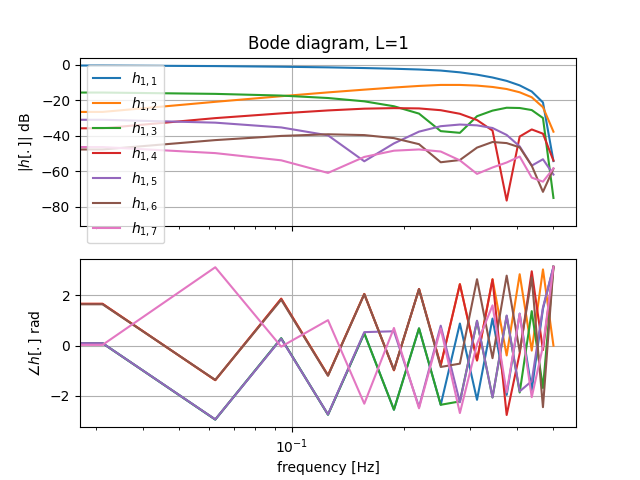

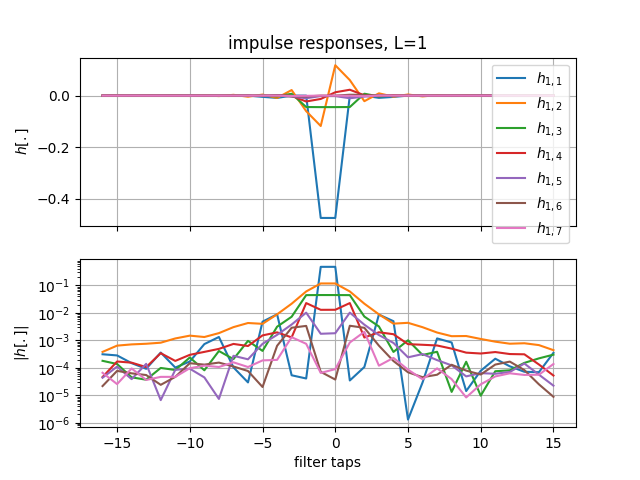

In [22]:
lstsq_estimator.plot_bode()
lstsq_estimator.plot_impulse_response()

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'impulse responses, L=1'}, ylabel='$h[.]$'>,
        <Axes: xlabel='filter taps', ylabel='$|h[.]|$'>], dtype=object))

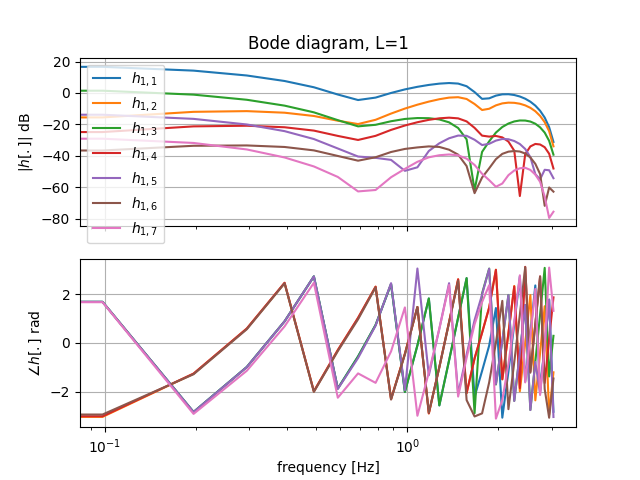

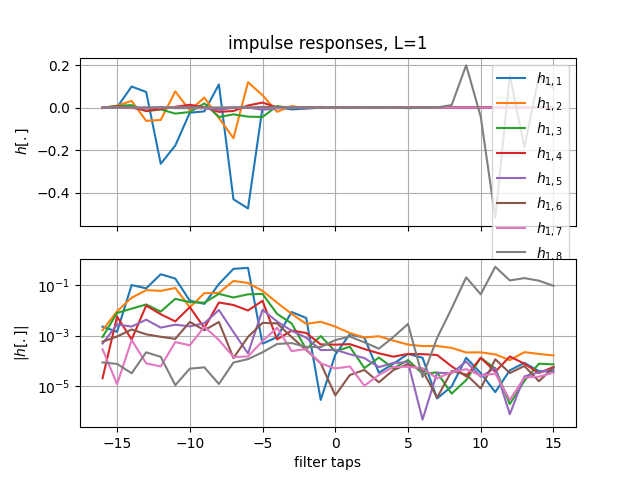

In [23]:
lstsq_iir_estimator.plot_bode()
lstsq_iir_estimator.plot_impulse_response()

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'impulse responses, L=1'}, ylabel='$h[.]$'>,
        <Axes: xlabel='filter taps', ylabel='$|h[.]|$'>], dtype=object))

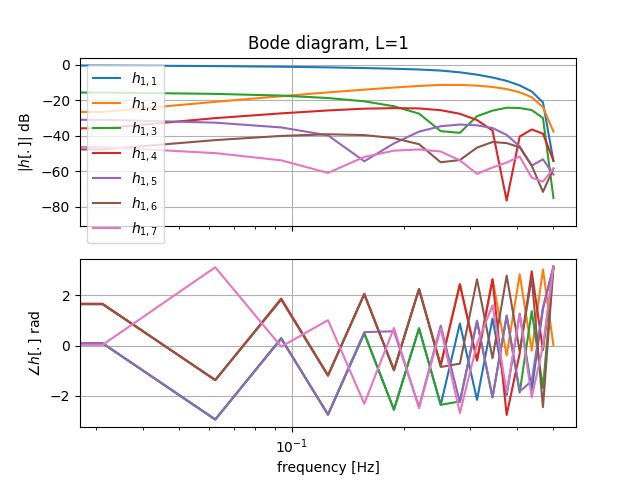

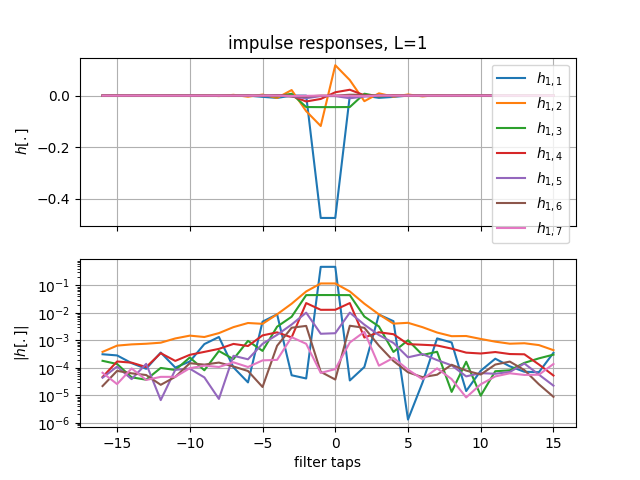

In [24]:
rls_estimator.plot_bode()
rls_estimator.plot_impulse_response()

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'impulse responses, L=1'}, ylabel='$h[.]$'>,
        <Axes: xlabel='filter taps', ylabel='$|h[.]|$'>], dtype=object))

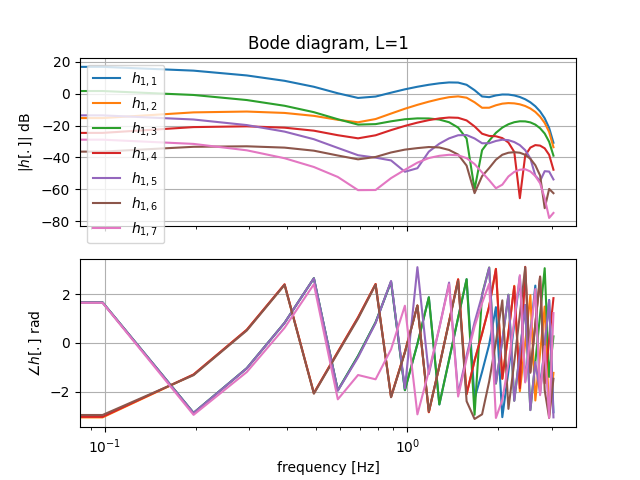

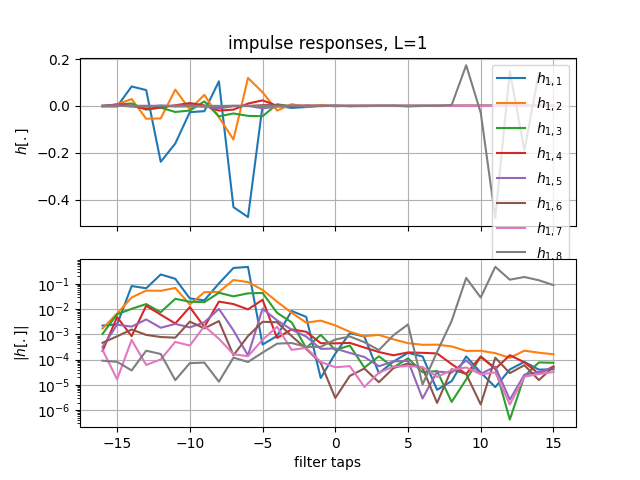

In [25]:
rls_iir_estimator.plot_bode()
rls_iir_estimator.plot_impulse_response()

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'impulse responses, L=1'}, ylabel='$h[.]$'>,
        <Axes: xlabel='filter taps', ylabel='$|h[.]|$'>], dtype=object))

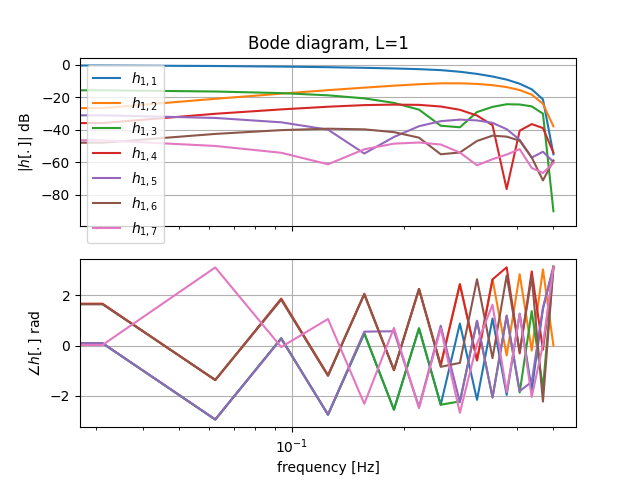

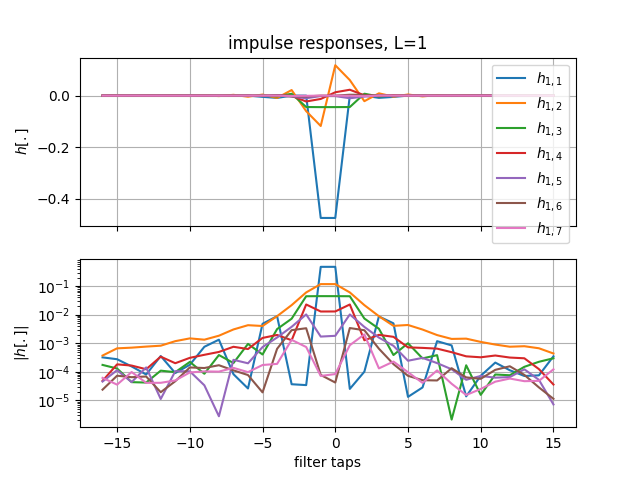

In [26]:
lms_estimator.plot_bode()
lms_estimator.plot_impulse_response()

(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'impulse responses, L=1'}, ylabel='$h[.]$'>,
        <Axes: xlabel='filter taps', ylabel='$|h[.]|$'>], dtype=object))

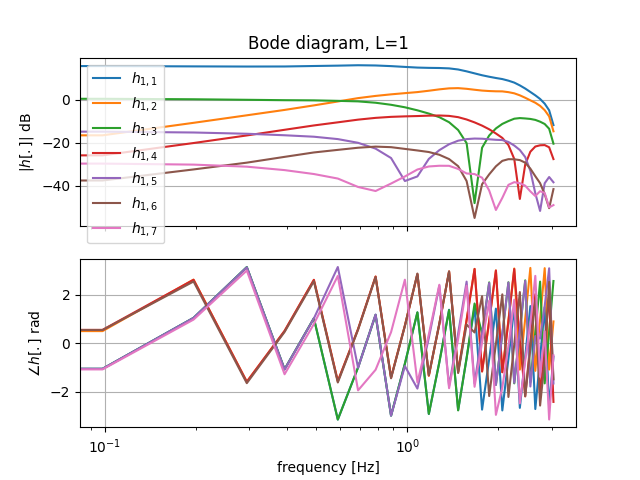

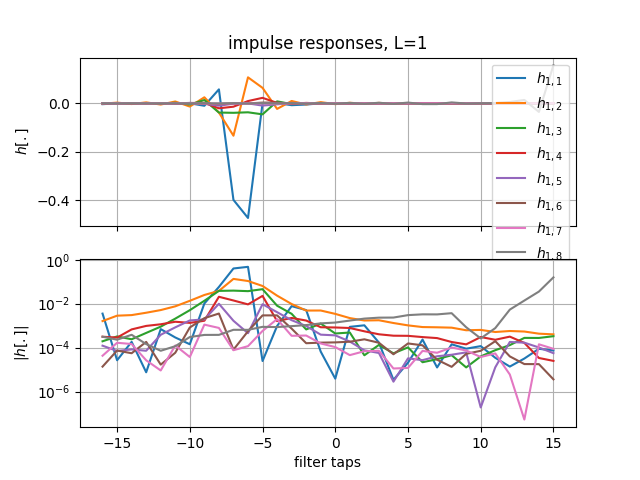

In [27]:
lms_iir_estimator.plot_bode()
lms_iir_estimator.plot_impulse_response()

In [28]:
# Compute LSTSQ test estimate
u_hat_lstsq = lstsq_estimator.predict(s_test_decimated).flatten()
# Compute LSTSQ IIR test estimate
u_hat_iir_lstsq = lstsq_iir_estimator.predict(s_test_decimated).flatten()
# Compute RLS test estimate
u_hat_rls = rls_estimator.predict(s_test_decimated).flatten()
# Compute RLS IIR test estimate
u_hat_iir_rls = rls_iir_estimator.predict(s_test_decimated).flatten()
# Compute LMS test estimate
u_hat_lms = lms_estimator.predict(s_test_decimated).flatten()
# Compute LMS IIR test estimate
u_hat_iir_lms = lms_iir_estimator.predict(s_test_decimated).flatten()

In [29]:
K_Wiener = 1 << 10
eta2 = (
    np.linalg.norm(
        analog_frontend.analog_system.transfer_function_matrix(
            np.array([2 * np.pi * BW])
        )
    )
    ** 2
)
wiener_filter = cbadc.digital_estimator.FIRFilter(
    analog_frontend.analog_system,
    analog_frontend.digital_control,
    eta2,
    K1=K_Wiener >> 1,
    K2=K_Wiener >> 1,
)
wiener_filter(cbadc.simulator.NumpySimulator('', (s_test + 1) / 2.0))
u_hat_wiener = np.zeros(simulation_length)
for i in cbadc.utilities.show_status(range(simulation_length)):
    u_hat_wiener[i] = next(wiener_filter)

u_hat_wiener_decimated = cbadc.digital_estimator.decimate(u_hat_wiener[K_Wiener >> 1:], DSR)
print(u_hat_wiener_decimated.shape)

INFO:cbadc.digital_estimator.batch_estimator:Computing filter coefficients. Using solver type: mpmath
INFO:cbadc.digital_estimator._filter_coefficients:Computing CARE analytically
INFO:cbadc.digital_estimator._filter_coefficients:Computing CARE analytically
  0%|          | 0/16384 [00:00<?, ?it/s]/tmp/ipykernel_374926/740522518.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_hat_wiener[i] = next(wiener_filter)
100%|██████████| 16384/16384 [00:00<00:00, 33567.68it/s]

(1984,)


Text(0, 0.5, 'amplitude')

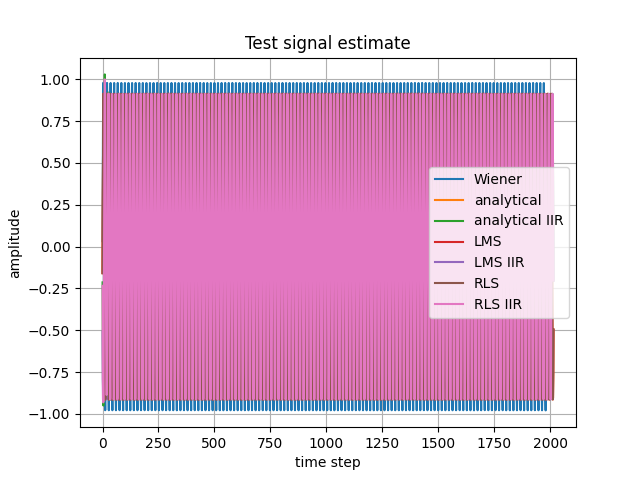

In [30]:
from_index = 0
to_index = u_hat_lstsq.shape[0]
plt.figure()

plt.plot(u_hat_wiener_decimated[from_index:to_index], label=f"Wiener")
plt.plot(u_hat_lstsq[from_index:to_index], label=f"analytical")
plt.plot(u_hat_iir_lstsq[from_index:to_index], label=f"analytical IIR")
plt.plot(u_hat_lms[from_index:to_index], label=f"LMS")
plt.plot(u_hat_iir_lms[from_index:to_index], label=f"LMS IIR")
plt.plot(u_hat_rls[from_index:to_index], label=f"RLS")
plt.plot(u_hat_iir_rls[from_index:to_index], label=f"RLS IIR")

plt.grid(True)
plt.title("Test signal estimate")
plt.legend()
plt.xlabel("time step")
plt.ylabel("amplitude")

Text(0, 0.5, 'PSD [dB]')

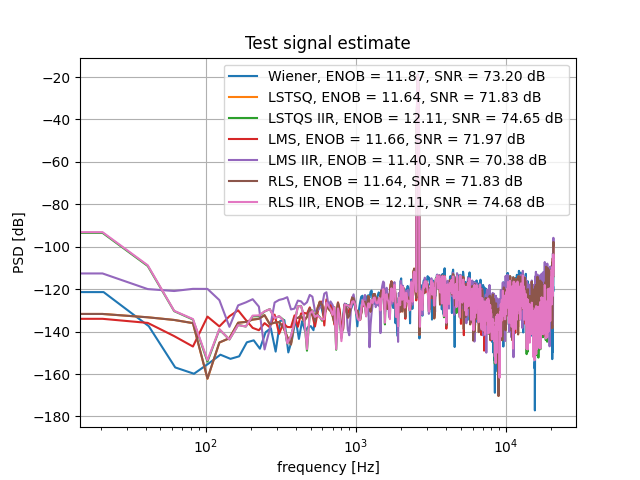

In [31]:
plt.figure()

f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat_wiener_decimated,
    fs=fs / DSR,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[:3] = False
noise_index[signal_index] = False
res = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=fs
)

SNR = 10 * np.log10(res["snr"])
est_ENOB = cbadc.fom.snr_to_enob(SNR)
plt.semilogx(f, 10 * np.log10(psd), label=f"Wiener, ENOB = {est_ENOB:.2f}, SNR = {SNR:.2f} dB")


f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat_lstsq,
    fs=fs / DSR,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[:3] = False
noise_index[signal_index] = False
res = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=fs
)

SNR = 10 * np.log10(res["snr"])
est_ENOB = cbadc.fom.snr_to_enob(SNR)
plt.semilogx(f, 10 * np.log10(psd), label=f"LSTSQ, ENOB = {est_ENOB:.2f}, SNR = {SNR:.2f} dB")

f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat_iir_lstsq,
    fs=fs / DSR,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[:3] = False
noise_index[signal_index] = False
res = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=fs
)

SNR = 10 * np.log10(res["snr"])
est_ENOB = cbadc.fom.snr_to_enob(SNR)
plt.semilogx(f, 10 * np.log10(psd), label=f"LSTQS IIR, ENOB = {est_ENOB:.2f}, SNR = {SNR:.2f} dB")



f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat_lms,
    fs=fs / DSR,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[:3] = False
noise_index[signal_index] = False
res = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=fs
)

SNR = 10 * np.log10(res["snr"])
est_ENOB = cbadc.fom.snr_to_enob(SNR)
plt.semilogx(f, 10 * np.log10(psd), label=f"LMS, ENOB = {est_ENOB:.2f}, SNR = {SNR:.2f} dB")

f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat_iir_lms,
    fs=fs / DSR,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[:3] = False
noise_index[signal_index] = False
res = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=fs
)

SNR = 10 * np.log10(res["snr"])
est_ENOB = cbadc.fom.snr_to_enob(SNR)
plt.semilogx(f, 10 * np.log10(psd), label=f"LMS IIR, ENOB = {est_ENOB:.2f}, SNR = {SNR:.2f} dB")


f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat_rls,
    fs=fs / DSR,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[:3] = False
noise_index[signal_index] = False
res = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=fs
)

SNR = 10 * np.log10(res["snr"])
est_ENOB = cbadc.fom.snr_to_enob(SNR)
plt.semilogx(f, 10 * np.log10(psd), label=f"RLS, ENOB = {est_ENOB:.2f}, SNR = {SNR:.2f} dB")

f, psd = cbadc.utilities.compute_power_spectral_density(
    u_hat_iir_rls,
    fs=fs / DSR,
)
signal_index = cbadc.utilities.find_sinusoidal(psd, 15)
noise_index = np.ones(psd.size, dtype=bool)
noise_index[:3] = False
noise_index[signal_index] = False

res = cbadc.utilities.snr_spectrum_computation_extended(
    psd, signal_index, noise_index, fs=fs
)

SNR = 10 * np.log10(res["snr"])
est_ENOB = cbadc.fom.snr_to_enob(SNR)
plt.semilogx(f, 10 * np.log10(psd), label=f"RLS IIR, ENOB = {est_ENOB:.2f}, SNR = {SNR:.2f} dB")

plt.grid(True)
plt.title("Test signal estimate")
plt.legend()
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [dB]")